# From Smote to Mix up In imbalanced Phishing Detection

This notebook presents a comprehensive workflow for detecting phishing emails using various machine learning techniques. We explore the performance of different models and data augmentation methods on imbalanced datasets.

## Set up

In this section, we install required libraries and set up the environment for our machine learning tasks.

In [1]:
pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.2 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=1fcf792180fa5cf7e71fc6e7d32cbae86ddf1e2c0d5a9d8043933f89e398f7b4
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from imblearn.over_sampling import SMOTE
from torch.autograd import Variable
from sklearn.utils import shuffle
from tqdm import tqdm
from sklearn.manifold import TSNE

## Dataset Preparation
We load, preprocess, and prepare the phishing email dataset for model training and evaluation.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
cd 'drive/MyDrive/UOttawa/CSI5388/project'

/content/drive/MyDrive/UOttawa/CSI5388/project


In [8]:
train_data = pd.read_csv("train.csv", lineterminator='\n')
test_data = pd.read_csv("test.csv", lineterminator='\n')

In [9]:
# sentence transformer model used to produce the embedding to train and test the model
model = SentenceTransformer('paraphrase-MiniLM-L3-v2')

.gitattributes:   0%|          | 0.00/690 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.01k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/69.6M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [13]:
train_embeddings = model.encode(train_data['Email Text'].tolist(), show_progress_bar=True)
test_embeddings = model.encode(test_data['Email Text'].tolist(), show_progress_bar=True)
test_embeddings_A = model.encode(test_data[test_data['dataset'] == 'A']['Email Text'].tolist(), show_progress_bar=True)
test_embeddings_B = model.encode(test_data[test_data['dataset'] == 'B']['Email Text'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/960 [00:00<?, ?it/s]

Batches:   0%|          | 0/659 [00:00<?, ?it/s]

Batches:   0%|          | 0/175 [00:00<?, ?it/s]

Batches:   0%|          | 0/484 [00:00<?, ?it/s]

### Visualizaiton (T-SNE)

In [14]:
label_A = test_data[test_data['dataset'] == 'A']['Email Type'].values
len(label_A)

5590

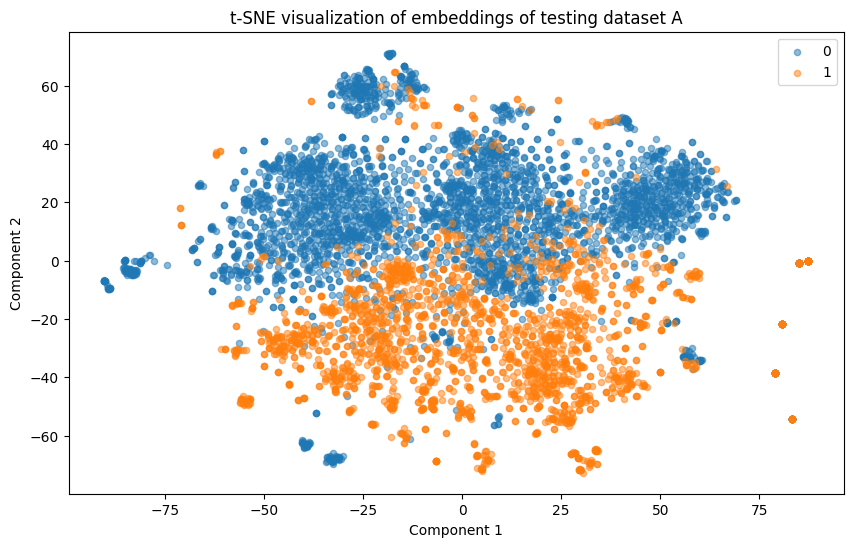

In [15]:
# Convert PyTorch tensor to NumPy array
embeddings = test_embeddings[:len(label_A), :]

# Run t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot the results
plt.figure(figsize=(10, 6))
for class_label in np.unique(label_A):
    indices = np.where(label_A == class_label)
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], alpha=0.5, label=str(class_label), s=20)

plt.legend()
plt.title("t-SNE visualization of embeddings of testing dataset A")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()


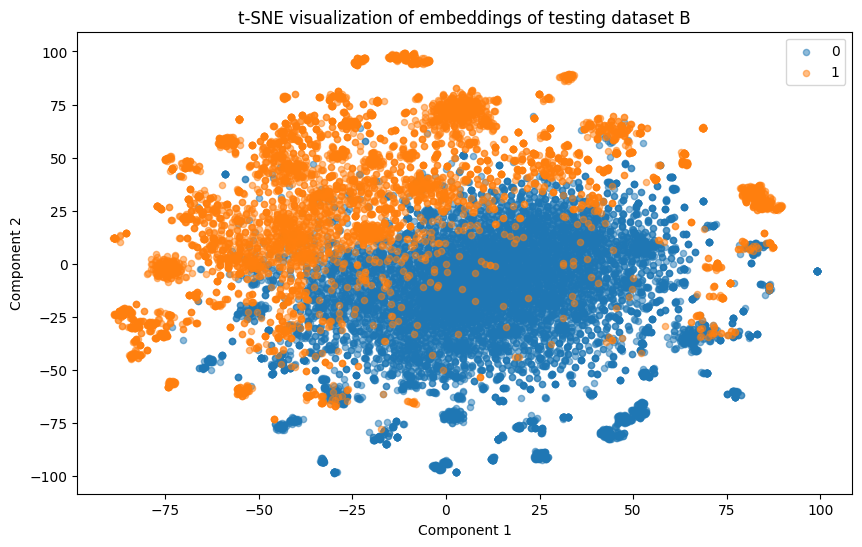

In [16]:
label_B = test_data[test_data['dataset'] == 'B']['Email Type'].values
len(label_B)

# Convert PyTorch tensor to NumPy array
embeddings = test_embeddings[len(label_A):, :]

# Run t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot the results
plt.figure(figsize=(10, 6))
for class_label in np.unique(label_B):
    indices = np.where(label_B == class_label)
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], alpha=0.5, label=str(class_label), s=20)

plt.legend()
plt.title("t-SNE visualization of embeddings of testing dataset B")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

In [17]:
label_A = train_data[train_data['dataset'] == 'A']['Email Type'].values
len(label_A)

8215

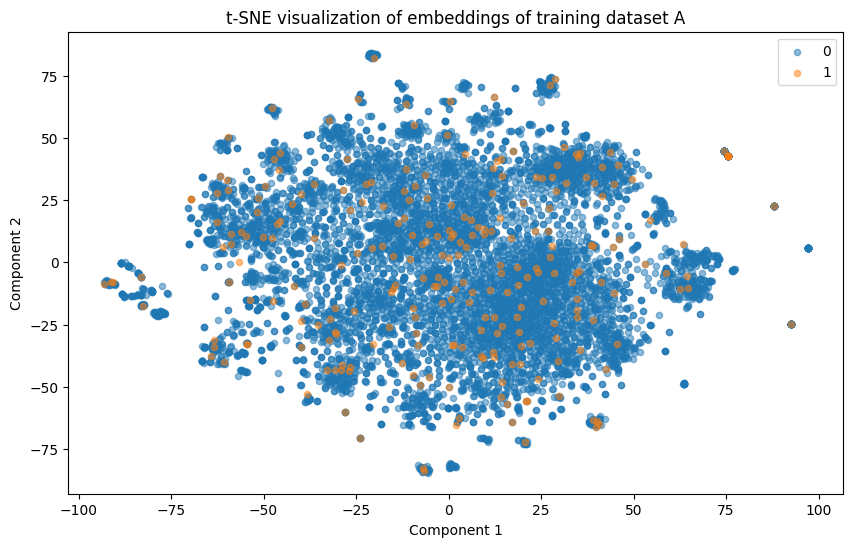

In [18]:
# Convert PyTorch tensor to NumPy array
embeddings = test_embeddings[:len(label_A), :]

# Run t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot the results
plt.figure(figsize=(10, 6))
for class_label in np.unique(label_A):
    indices = np.where(label_A == class_label)
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], alpha=0.5, label=str(class_label), s=20)

plt.legend()
plt.title("t-SNE visualization of embeddings of training dataset A")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()


In [19]:
label_B = train_data[train_data['dataset'] == 'B']['Email Type'].values
len(label_B)

22476

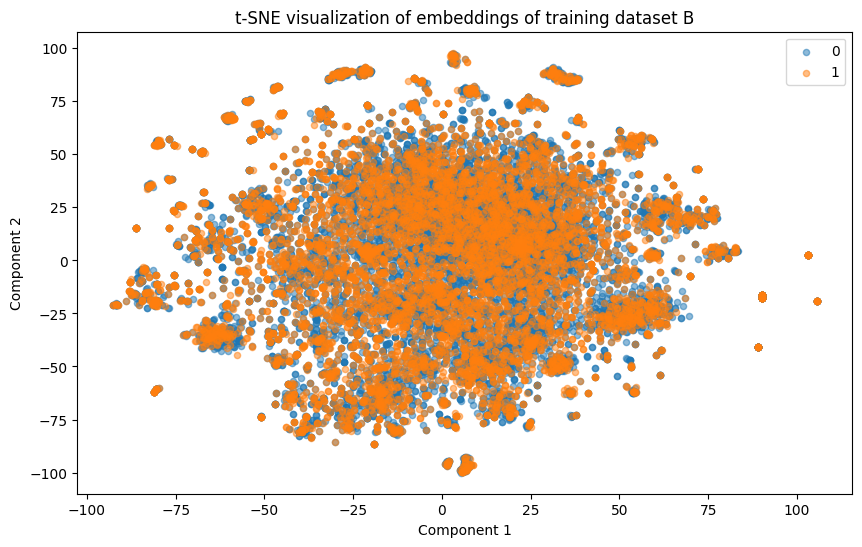

In [20]:
label_B = test_data[test_data['dataset'] == 'B']['Email Type'].values
len(label_B)
# Convert PyTorch tensor to NumPy array
embeddings = test_embeddings[:len(label_B), :]

# Run t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot the results
plt.figure(figsize=(10, 6))
for class_label in np.unique(label_B):
    indices = np.where(label_B == class_label)
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], alpha=0.5, label=str(class_label), s=20)

plt.legend()
plt.title("t-SNE visualization of embeddings of training dataset B")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

## Model Building
Here we define and initialize the deep learning models that will be used to classify emails.

In [ ]:
# define MLP model
class MLP(nn.Module):
    def __init__(self, embed_dim, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(embed_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        return x

# define the dimmension, number of classes
embed_dim = train_embeddings.shape[1]
num_classes = 2

model = MLP(embed_dim, num_classes).to(device)

In [ ]:
# define logistic regression model
class LogisticRegression(nn.Module):
    def __init__(self, embed_dim):
        super(LogisticRegression, self).__init__()
        self.layer = nn.Linear(in_features = embed_dim, out_features=2)
    def forward(self, x):
        return self.layer(x)

model2 = LogisticRegression(embed_dim).to(device)

In [ ]:
# define CNN model
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(64 * 96, num_classes)

    def forward(self, x):
        # if need, adjust shape of x
        if x.dim() == 2:
            x = x.unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = F.max_pool1d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, 2)
        x = x.view(x.size(0), -1) 
        x = self.fc(x)
        return x

embed_dim = train_embeddings.shape[1]
num_classes = 2
# model3 = CNN(embed_dim, num_classes).to(device)
model3 = CNN(num_classes).to(device)

In [ ]:
X_train, X_test_A, X_test_B, y_train, y_test_A, y_test_B = train_embeddings, test_embeddings_A, test_embeddings_B, train_data['Email Type'], test_data[test_data['dataset'] == 'A']['Email Type'], test_data[test_data['dataset'] == 'B']['Email Type']

In [ ]:
smote = SMOTE(random_state = 123)
X_train_smote, y_train_smote = smote.fit_resample(X_train,y_train)

In [ ]:
import numpy as np
import torch
from sklearn.neighbors import NearestNeighbors

def neighbor_mix_upsampling(X_train, y_train, minority_class, majority_class_size, alpha=1.0):
    '''Upsamples the minority class in the dataset using the Neighbor-Mix approach to match the majority class size'''

    # Convert to PyTorch tensors if they aren't already
    X_train = torch.tensor(X_train, dtype=torch.float32) if not isinstance(X_train, torch.Tensor) else X_train
    y_train = torch.tensor(y_train, dtype=torch.float32) if not isinstance(y_train, torch.Tensor) else y_train

    # Identify minority class samples
    minority_indices = torch.where(y_train == minority_class)[0]

    # Determine the number of synthetic samples needed
    n_to_sample = majority_class_size - len(minority_indices)

    # NearestNeighbors model
    n_neighbors = 3  # Adjust based on your dataset size
    nn = NearestNeighbors(n_neighbors=n_neighbors)
    nn.fit(X_train)

    # Generate indices for sampling
    base_indices = np.random.choice(minority_indices, n_to_sample, replace=True)
    neighbor_indices = np.random.choice(list(range(1, n_neighbors)), n_to_sample)

    # Find base samples and their neighbors
    X_base = X_train[base_indices]
    _, ind = nn.kneighbors(X_base)
    X_neighbor = X_train[ind[np.arange(n_to_sample), neighbor_indices]]

    # Convert lam to a PyTorch tensor and ensure it's one-dimensional for label calculations
    lam = torch.from_numpy(np.random.beta(alpha, alpha, n_to_sample)).view(-1, 1)

    # Generate synthetic samples and labels
    synthetic_samples = lam * X_base + (1 - lam) * X_neighbor
    synthetic_labels = lam * y_train[base_indices].view(-1, 1) + (1 - lam) * y_train[ind[np.arange(n_to_sample), neighbor_indices]].view(-1, 1)

    # Ensure both y_train and synthetic_labels are one-dimensional
    y_train = y_train.view(-1)
    synthetic_labels = synthetic_labels.view(-1)

    # Append synthetic samples and labels to the original training data
    X_train_augmented = torch.vstack([X_train, synthetic_samples])
    y_train_augmented = torch.cat([y_train, synthetic_labels])


    return X_train_augmented, y_train_augmented


In [ ]:
X_train_nx, y_train_nx = neighbor_mix_upsampling(X_train,y_train,minority_class=1, majority_class_size=len(y_train==0))

In [ ]:
# convert numpy to tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_train_smote_tensor = torch.tensor(X_train_smote, dtype = torch.float32)
y_train_smote_tensor = torch.tensor(y_train_smote.values, dtype = torch.long)
X_train_nx_tensor = torch.tensor(X_train_nx, dtype = torch.float32)
y_train_nx_tensor = torch.tensor(y_train_nx, dtype = torch.long)
X_test_A_tensor = torch.tensor(X_test_A, dtype=torch.float32)
y_test_A_tensor = torch.tensor(y_test_A.values, dtype=torch.long)
X_test_B_tensor = torch.tensor(X_test_B, dtype=torch.float32)
y_test_B_tensor = torch.tensor(y_test_B.values, dtype=torch.long)

# Create TensorDatasets and DataLoaders
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_data_smote = TensorDataset(X_train_smote_tensor, y_train_smote_tensor)
test_data_A = TensorDataset(X_test_A_tensor, y_test_A_tensor)
test_data_B = TensorDataset(X_test_B_tensor, y_test_B_tensor)

train_data_nx = TensorDataset(X_train_nx_tensor, y_train_nx_tensor)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
train_loader_smote = DataLoader(train_data_smote, batch_size=32, shuffle=True)
train_loader_nx = DataLoader(train_data_nx, batch_size=32, shuffle=True)
test_loader_A = DataLoader(test_data_A, batch_size=32)
test_loader_B = DataLoader(test_data_B, batch_size=32)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
# criterion1 = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer2 = optim.Adam(model2.parameters(),lr=0.001)
optimizer3= optim.Adam(model3.parameters(),lr=0.001)

<ipython-input-38-d90a69728a9c>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_nx_tensor = torch.tensor(X_train_nx, dtype = torch.float32)
<ipython-input-38-d90a69728a9c>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_nx_tensor = torch.tensor(y_train_nx, dtype = torch.long)


## Different data augmentation methods
Neighbor mix method and smote mix method that will be used later are defined here.

In [ ]:
# smote mix up function mixed up the value that producing by smote interpolation
def smote_mix_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs with same-class targets, and lambda for SMOTE-Mix'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        x = x.cuda()
        y = y.cuda()

    # Find the nearest neighbor of the same type for each sample
    mixed_x = torch.zeros_like(x)
    y_a = torch.zeros_like(y)
    y_b = torch.zeros_like(y)

    for i in range(batch_size):
        # Select samples of the same type as the i-th sample
        same_class_indices = (y == y[i]).nonzero().squeeze()
        # Remove itself
        same_class_indices = same_class_indices[same_class_indices != i]
        if len(same_class_indices) == 0:
            # If there is no similar sample, select itself
            j = i
        else:
            j = np.random.choice(same_class_indices.cpu().numpy())

        # Perform SMOTE interpolation
        mixed_x[i] = lam * x[i] + (1 - lam) * x[j]
        y_a[i], y_b[i] = y[i], y[j]

    return mixed_x, y_a, y_b, lam

In [ ]:
# criterion used in smote mix
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

## Training and Evaluation
In this part, we train the models using different strategies and evaluate their performance on the test data.

In [ ]:
def train_test(model, train_loader, test_loader, criterion, optimizer, epochs=5, use_neighbor_mix = False, use_smote_mix = False):
    acc = []
    all_features = []
    all_preds = []
    all_labels = []
    probs = []
    for epoch in tqdm(range(epochs)):
        # model train
        model.train()
        # total_loss = 0
        total = 0
        correct = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            if use_smote_mix:
              # use smote mix on data
              inputs, targets_a, targets_b, lam = smote_mix_data(inputs, targets, use_cuda=False)
              inputs, targets_a, targets_b = map(Variable, (inputs,targets_a, targets_b))
              # forward propagation
              outputs = model(inputs)
              # calculate metrics, then backward propagation and update parameter
              loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
              train_loss = loss.item()
              _, predicted = torch.max(outputs.data, 1)
              total += targets.size(0)
              correct += (lam * predicted.eq(targets_a.data).cpu().sum().float()
                          + (1 - lam) * predicted.eq(targets_b.data).cpu().sum().float())
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
            else:
              # forward propagation
              optimizer.zero_grad()
              outputs = model(inputs)
              # calculate metrics, then backward propagation and update parameter
              loss = criterion(outputs.squeeze(), targets)
              loss.backward()
              optimizer.step()
              # total_loss += loss.item()

        # print(f'Epoch {epoch+1}/{epochs}, Training loss: {total_loss/len(train_loader)}')

        # model test
        model.eval()
        total = 0
        correct = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)
                prob = torch.sigmoid(outputs).cpu()
                probs.extend(prob.numpy())
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)

                if use_smote_mix:
                    correct += predicted.eq(targets.data).cpu().sum()
                else:
                    correct += (predicted == targets).sum().item()
                # calculate and record metrics
                accuracy = correct / total
                all_features.extend(inputs.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(targets.cpu().numpy())
                acc.append(accuracy)

    precision = precision_score(all_labels, all_preds,average = 'binary')
    recall = recall_score(all_labels, all_preds,average = 'binary')
    f1 = f1_score(all_labels, all_preds,average = 'binary')

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Accuracy: {100 * correct / total}%')
    return precision, recall, f1, correct / total, acc, all_features, all_preds, all_labels, probs

In [ ]:
from sklearn.metrics import roc_curve, auc

In [ ]:
def plot_multiple_roc_curves(y_trues, probs, labels, model = 'roc'):
    plt.figure()

    for y, prob, label in zip(y_trues, probs, labels):
        prob = np.array(prob)
        prob = prob[:, 1] if prob.ndim > 1 else prob

        # Calculate ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y, prob)
        roc_auc = auc(fpr, tpr)

        # Plotting ROC curves
        plt.plot(fpr, tpr, lw=2, label=f'{label} (area = {roc_auc:.2f})')

    # Drawing Diagonal Lines
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(model)
    plt.legend(loc="lower right")
    plt.show()

### MLP test

In [ ]:
model = MLP(embed_dim, num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
mlp_precision_A, mlp_recall_A, mlp_f1_A, mlp_accuracy_A, mlp_A, mlp_var_A, mlp_preds_A, mlp_y_A, mlp_probs_A = train_test(model, train_loader, test_loader_A, criterion, optimizer, epochs=10)

100%|██████████| 10/10 [00:28<00:00,  2.87s/it]


Precision: 0.9796
Recall: 0.6572
F1 Score: 0.7867
Accuracy: 86.17173524150269%


In [ ]:
model = MLP(embed_dim, num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
mlp_smote_precision_A, mlp_smote_recall_A, mlp_smote_f1_A, mlp_smote_accuracy_A, mlp_smote_A, mlp_smote_var_A, mlp_smote_preds_A, mlp_smote_y_A, mlp_smote_probs_A = train_test(model, train_loader_smote, test_loader_A, criterion, optimizer, epochs=10)

100%|██████████| 10/10 [00:52<00:00,  5.26s/it]

Precision: 0.9476
Recall: 0.8094
F1 Score: 0.8731
Accuracy: 89.2665474060823%


In [ ]:
model = MLP(embed_dim, num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
mlp_mix_precision_A, mlp_mix_recall_A, mlp_mix_f1_A, mlp_mix_accuracy_A, mlp_neighbor_A,mlp_mix_var_A, mlp_mix_preds_A, mlp_mix_y_A, mlp_mix_probs_A = train_test(model, train_loader_nx, test_loader_A, criterion, optimizer, epochs=10)

100%|██████████| 10/10 [00:51<00:00,  5.19s/it]

Precision: 0.9916
Recall: 0.5156
F1 Score: 0.6784
Accuracy: 79.5169946332737%


In [ ]:
model = MLP(embed_dim, num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
mlp_smote_mix_precision_A, mlp_smote_mix_recall_A, mlp_smote_mix_f1_A, mlp_smote_mix_accuracy_A, mlp_smote_mix_A, mlp_sm_var_A, mlp_sm_preds_A, mlp_sm_y_A, mlp_smote_mix_probs_A = train_test(model, train_loader, test_loader_A, criterion, optimizer, use_smote_mix = True, epochs=10)

100%|██████████| 10/10 [02:25<00:00, 14.51s/it]

Precision: 0.9490
Recall: 0.7593
F1 Score: 0.8436
Accuracy: 91.68157196044922%


In [ ]:
model = MLP(embed_dim, num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
mlp_precision_B, mlp_recall_B, mlp_f1_B, mlp_accuracy_B, mlp_B, mlp_var_B, mlp_preds_B, mlp_y_B, mlp_probs_B = train_test(model, train_loader, test_loader_B, criterion, optimizer, epochs=10)


100%|██████████| 10/10 [00:33<00:00,  3.38s/it]


Precision: 0.9907
Recall: 0.7273
F1 Score: 0.8388
Accuracy: 88.79048419419485%


In [ ]:
model = MLP(embed_dim, num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
mlp_smote_precision_B, mlp_smote_recall_B, mlp_smote_f1_B, mlp_smote_accuracy_B, mlp_smote_B, mlp_smote_var_B, mlp_smote_preds_B, mlp_smote_y_B, mlp_smote_probs_B = train_test(model, train_loader_smote, test_loader_B, criterion, optimizer, epochs=10)

100%|██████████| 10/10 [00:58<00:00,  5.88s/it]


Precision: 0.9876
Recall: 0.8140
F1 Score: 0.8924
Accuracy: 91.48619820285732%


In [ ]:
model = MLP(embed_dim, num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
mlp_mix_precision_B, mlp_mix_recall_B, mlp_mix_f1_B, mlp_mix_accuracy_B, mlp_neighbor_B, mlp_mix_var_B, mlp_mix_preds_B, mlp_mix_y_B, mlp_mix_probs_B = train_test(model, train_loader_nx, test_loader_B, criterion, optimizer, epochs=10)


100%|██████████| 10/10 [01:03<00:00,  6.38s/it]


Precision: 0.9959
Recall: 0.6145
F1 Score: 0.7600
Accuracy: 83.69642510828108%


In [ ]:
model = MLP(embed_dim, num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
mlp_smote_mix_precision_B, mlp_smote_mix_recall_B, mlp_smote_mix_f1_B, mlp_smote_mix_accuracy_B, mlp_smote_mix_B, mlp_sm_var_B, mlp_sm_preds_B, mlp_sm_y_B, mlp_smote_mix_probs_B = train_test(model, train_loader, test_loader_B, criterion, optimizer, use_smote_mix = True, epochs=10)


100%|██████████| 10/10 [02:46<00:00, 16.66s/it]


Precision: 0.9694
Recall: 0.8130
F1 Score: 0.8843
Accuracy: 92.55931091308594%


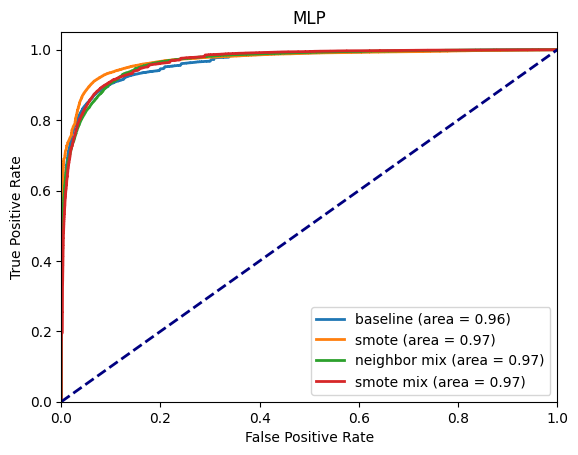

In [ ]:
y_trues = [mlp_y_A, mlp_smote_y_A, mlp_mix_y_A, mlp_sm_y_A]  
probs = [mlp_probs_A, mlp_smote_probs_A, mlp_mix_probs_A, mlp_smote_mix_probs_A]       
labels = ['baseline','smote', 'neighbor mix','smote mix']  

plot_multiple_roc_curves(y_trues, probs, labels,'MLP')

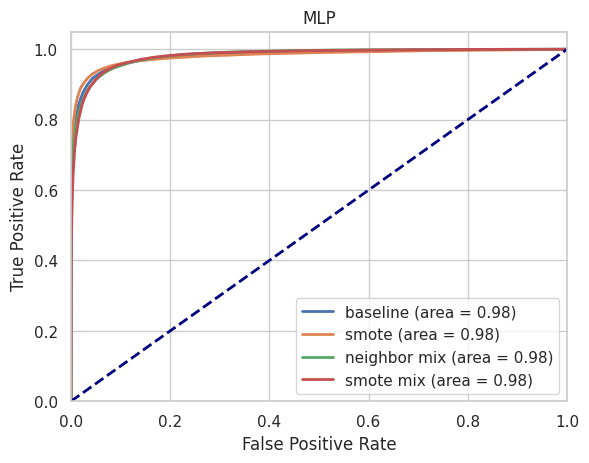

In [ ]:
y_trues = [mlp_y_B, mlp_sm_y_B, mlp_mix_y_B, mlp_sm_y_B]  
probs = [mlp_probs_B, mlp_smote_probs_B, mlp_mix_probs_B, mlp_smote_mix_probs_B]  
labels = ['baseline', 'smote', 'neighbor mix', 'smote mix']  

plot_multiple_roc_curves(y_trues, probs, labels, 'MLP')


### LR test

In [ ]:
model2 = LogisticRegression(embed_dim).to(device)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
lr_precision_A, lr_recall_A, lr_f1_A, lr_accuracy_A, test_lr_A, lr_var_A, lr_preds_A, lr_y_A, lr_probs_A  = train_test(model2, train_loader, test_loader_A, criterion, optimizer2, epochs=10)

100%|██████████| 10/10 [00:14<00:00,  1.48s/it]

Precision: 0.9837
Recall: 0.3703
F1 Score: 0.5380
Accuracy: 77.90697674418605%


In [ ]:
model2 = LogisticRegression(embed_dim).to(device)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
lr_smote_precision_A, lr_smote_recall_A, lr_smote_f1_A, lr_smote_accuracy_A, test_lr_smote_A, lr_smote_var_A, lr_smote_preds, lr_smote_y_A, lr_smote_probs_A  = train_test(model2, train_loader_smote, test_loader_A, criterion, optimizer2, epochs=10)

100%|██████████| 10/10 [00:40<00:00,  4.03s/it]


Precision: 0.8319
Recall: 0.8990
F1 Score: 0.8641
Accuracy: 89.40966010733453%


In [ ]:
model2 = LogisticRegression(embed_dim).to(device)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
lr_mix_precision_A, lr_mix_recall_A, lr_mix_f1_A, lr_mix_accuracy_A, test_lr_neighbor_mix_A, lr_mix_var_A, lr_mix_preds_A, lr_mix_y_A, lr_mix_probs_A = train_test(model2, train_loader_nx, test_loader_A, criterion, optimizer2, epochs=10)

100%|██████████| 10/10 [00:38<00:00,  3.81s/it]


Precision: 0.9351
Recall: 0.6193
F1 Score: 0.7451
Accuracy: 83.13059033989266%


In [ ]:
model2 = LogisticRegression(embed_dim).to(device)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
lr_smote_mix_precision_A, lr_smote_mix_recall_A, lr_smote_mix_f1_A, lr_smote_mix_accuracy_A, test_lr_smote_mix_A, lr_sm_var, lr_sm_preds_A, lr_sm_y_A, lr_sm_probs_A  = train_test(model2, train_loader, test_loader_A, criterion, optimizer2, use_smote_mix = True, epochs=10)

100%|██████████| 10/10 [02:28<00:00, 14.90s/it]


Precision: 0.9572
Recall: 0.4797
F1 Score: 0.6391
Accuracy: 82.02146911621094%


In [ ]:
model2 = LogisticRegression(embed_dim).to(device)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
lr_precision_B, lr_recall_B, lr_f1_B, lr_accuracy_B, test_lr_B, lr_var_B, lr_preds_B, lr_y_B, lr_probs_B = train_test(model2, train_loader, test_loader_B, criterion, optimizer2, epochs=10)


100%|██████████| 10/10 [00:20<00:00,  2.05s/it]


Precision: 0.9922
Recall: 0.4133
F1 Score: 0.5836
Accuracy: 79.71426724416575%


In [ ]:
model2 = LogisticRegression(embed_dim).to(device)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
lr_smote_precision_B, lr_smote_recall_B, lr_smote_f1_B, lr_smote_accuracy_B, test_lr_smote_B, lr_smote_var_B, lr_smote_preds_B, lr_smote_y_B, lr_smote_probs_B = train_test(model2, train_loader_smote, test_loader_B, criterion, optimizer2, epochs=10)


100%|██████████| 10/10 [00:30<00:00,  3.08s/it]


Precision: 0.9155
Recall: 0.8739
F1 Score: 0.8942
Accuracy: 92.11325877561575%


In [ ]:
model2 = LogisticRegression(embed_dim).to(device)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
lr_mix_precision_B, lr_mix_recall_B, lr_mix_f1_B, lr_mix_accuracy_B, test_lr_neighbor_mix_B, lr_mix_var_B, lr_mix_preds_B, lr_mix_y_B, lr_mix_probs_B = train_test(model2, train_loader_nx, test_loader_B, criterion, optimizer2, epochs=10)


100%|██████████| 10/10 [00:33<00:00,  3.32s/it]


Precision: 0.9626
Recall: 0.6500
F1 Score: 0.7760
Accuracy: 84.98933350572112%


In [ ]:
model2 = LogisticRegression(embed_dim).to(device)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
lr_smote_mix_precision_B, lr_smote_mix_recall_B, lr_smote_mix_f1_B, lr_smote_mix_accuracy_B, test_lr_smote_mix_B, lr_sm_var_B, lr_sm_preds_B, lr_sm_y_B, lr_sm_probs_B = train_test(model2, train_loader, test_loader_B, criterion, optimizer2, use_smote_mix = True, epochs=10)


100%|██████████| 10/10 [02:27<00:00, 14.77s/it]


Precision: 0.9829
Recall: 0.5065
F1 Score: 0.6685
Accuracy: 82.5263442993164%


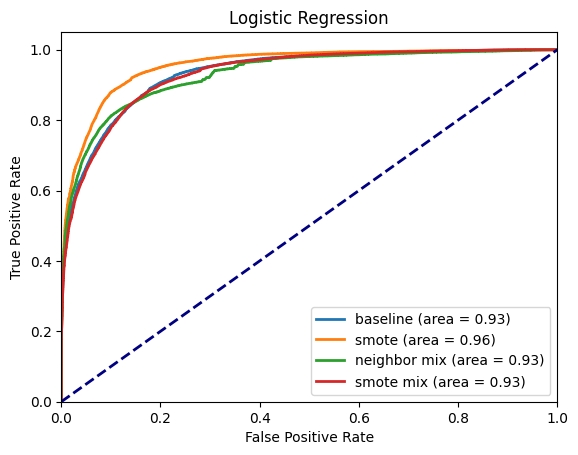

In [ ]:
y_trues = [lr_y_A, lr_smote_y_A, lr_mix_y_A, lr_sm_y_A]  
probs = [lr_probs_A, lr_smote_probs_A, lr_mix_probs_A, lr_sm_probs_A]       
labels = ['baseline','smote', 'neighbor mix','smote mix'] 

plot_multiple_roc_curves(y_trues, probs, labels, 'Logistic Regression')

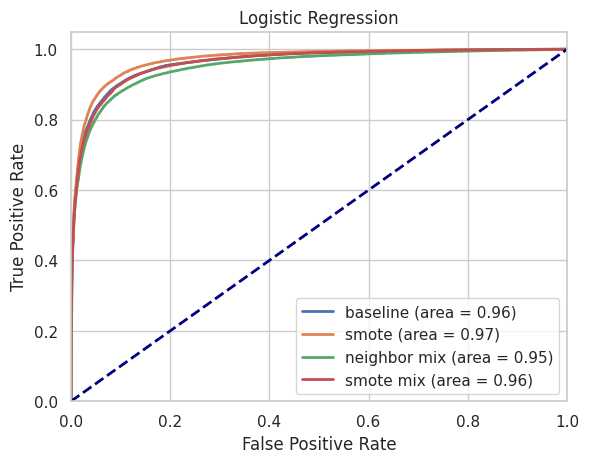

In [ ]:
y_trues = [lr_y_B, lr_smote_y_B, lr_mix_y_B, lr_sm_y_B]  
probs = [lr_probs_B, lr_smote_probs_B, lr_mix_probs_B, lr_sm_probs_B]  
labels = ['baseline', 'smote', 'neighbor mix', 'smote mix']  

plot_multiple_roc_curves(y_trues, probs, labels, 'Logistic Regression')


# CNN

In [ ]:
model3 = CNN(num_classes).to(device)
optimizer3 = optim.Adam(model3.parameters(), lr=0.001)
cnn_precision_A, cnn_recall_A, cnn_f1_A, cnn_accuracy_A, cnn_A, cnn_var_A, cnn_preds_A, cnn_y_A, cnn_probs_A = train_test(model3, train_loader, test_loader_A, criterion, optimizer3, epochs=10)

100%|██████████| 10/10 [00:47<00:00,  4.79s/it]


Precision: 0.9809
Recall: 0.3954
F1 Score: 0.5636
Accuracy: 78.71198568872987%


In [ ]:
cnn_smote_precision_A, cnn_smote_recall_A, cnn_smote_f1_A, cnn_smote_accuracy_A, cnn_smote_A, cnn_smote_var_A, cnn_smote_preds_A, cnn_smote_y_A, cnn_smote_probs_A = train_test(model3, train_loader_smote, test_loader_A, criterion, optimizer3, epochs=10)

100%|██████████| 10/10 [00:45<00:00,  4.56s/it]

Precision: 0.9381
Recall: 0.6210
F1 Score: 0.7473
Accuracy: 82.82647584973166%


In [ ]:
cnn_nx_precision_A, cnn_nx_recall_A, cnn_nx_f1_A, cnn_nx_accuracy_A, cnn_nx_A, cnn_nx_var_A, cnn_nx_preds_A, cnn_nx_y_A, cnn_nx_probs_A = train_test(model3, train_loader_nx, test_loader_A, criterion, optimizer3, epochs=10)

100%|██████████| 10/10 [01:04<00:00,  6.40s/it]

Precision: 0.9813
Recall: 0.4289
F1 Score: 0.5969
Accuracy: 79.01610017889088%


In [ ]:
cnn_smote_mix_precision_A, cnn_smote_mix_recall_A, cnn_smote_mix_f1_A, cnn_smote_mix_accuracy_A, cnn_smote_mix_A, cnn__sm_var_A, cnn__sm_preds_A, cnn__sm_y_A, cnn__sm_probs_A  = train_test(model3, train_loader, test_loader_A, criterion, optimizer3, use_smote_mix = True, epochs=10)

100%|██████████| 10/10 [03:20<00:00, 20.09s/it]

Precision: 0.9412
Recall: 0.6434
F1 Score: 0.7643
Accuracy: 84.74060821533203%


In [ ]:
model3 = CNN(num_classes).to(device)
optimizer3 = optim.Adam(model3.parameters(), lr=0.001)
cnn_precision_B, cnn_recall_B, cnn_f1_B, cnn_accuracy_B, cnn_B, cnn_var_B, cnn_preds_B, cnn_y_B, cnn_probs_B = train_test(model3, train_loader, test_loader_B, criterion, optimizer3, epochs=10)


100%|██████████| 10/10 [00:29<00:00,  2.95s/it]


Precision: 0.9923
Recall: 0.5066
F1 Score: 0.6708
Accuracy: 81.85403064192901%


In [ ]:
cnn_smote_precision_B, cnn_smote_recall_B, cnn_smote_f1_B, cnn_smote_accuracy_B, cnn_smote_B, cnn_smote_var_B, cnn_smote_preds_B, cnn_smote_y_B, cnn_smote_probs_B = train_test(model3, train_loader_smote, test_loader_B, criterion, optimizer3, epochs=10)

100%|██████████| 10/10 [00:56<00:00,  5.62s/it]


Precision: 0.9772
Recall: 0.6946
F1 Score: 0.8120
Accuracy: 87.10970327752278%


In [ ]:
cnn_nx_precision_B, cnn_nx_recall_B, cnn_nx_f1_B, cnn_nx_accuracy_B, cnn_nx_B, cnn_nx_var_B, cnn_nx_preds_B, cnn_nx_y_B, cnn_nx_probs_B = train_test(model3, train_loader_nx, test_loader_B, criterion, optimizer3, epochs=10)

100%|██████████| 10/10 [00:52<00:00,  5.24s/it]


Precision: 0.9880
Recall: 0.5433
F1 Score: 0.7011
Accuracy: 82.53280755058505%


In [ ]:
cnn_smote_mix_precision_B, cnn_smote_mix_recall_B, cnn_smote_mix_f1_B, cnn_smote_mix_accuracy_B, cnn_smote_mix_B, cnn_sm_var_B, cnn_sm_preds_B, cnn_sm_y_B, cnn_sm_probs_B = train_test(model3, train_loader, test_loader_B, criterion, optimizer3, use_smote_mix = True, epochs=10)


100%|██████████| 10/10 [02:35<00:00, 15.53s/it]


Precision: 0.9799
Recall: 0.6818
F1 Score: 0.8041
Accuracy: 86.23052215576172%


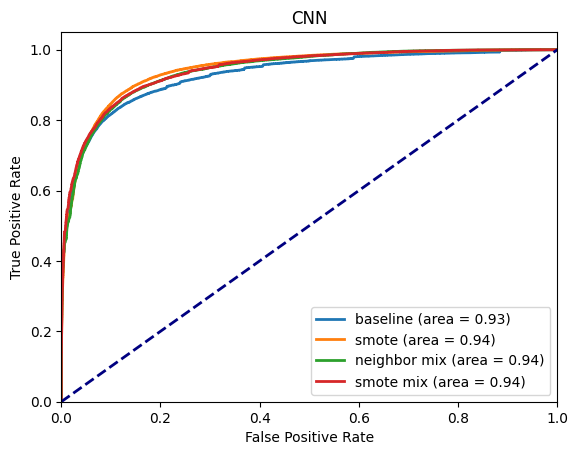

In [ ]:
y_trues = [cnn_y_A, cnn_smote_y_A, cnn_nx_y_A, cnn__sm_y_A]  
probs = [cnn_probs_A, cnn_smote_probs_A, cnn_nx_probs_A, cnn__sm_probs_A]       
labels = ['baseline','smote', 'neighbor mix','smote mix']  

plot_multiple_roc_curves(y_trues, probs, labels,'CNN')

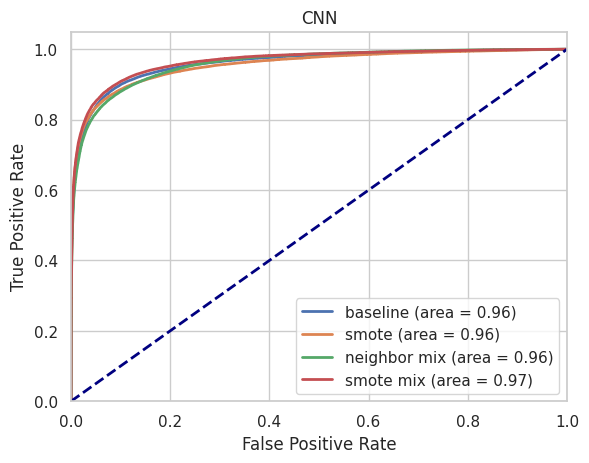

In [ ]:
y_trues = [cnn_y_B, cnn_smote_y_B, cnn_nx_y_B, cnn_sm_y_B] 
probs = [cnn_probs_B, cnn_smote_probs_B, cnn_nx_probs_B, cnn_sm_probs_B]  
labels = ['baseline', 'smote', 'neighbor mix', 'smote mix']  

plot_multiple_roc_curves(y_trues, probs, labels, 'CNN')


## Visualization
We visualize the performance metrics of the models to compare methods' effectiveness.

In [ ]:
data_dict = {
    "Model": ["CNN", "CNN", "CNN", "CNN", "LR", "LR", "LR", "LR", "MLP", "MLP", "MLP", "MLP"],
    "Method": ["Baseline", "SMOTE", "Neighbor Mix", "SMOTE Mix", "Baseline", "SMOTE", "Neighbor Mix", "SMOTE Mix", "Baseline", "SMOTE", "Neighbor Mix", "SMOTE Mix"],
    "Precision": [cnn_precision_A, cnn_smote_precision_A, cnn_nx_precision_A, cnn_smote_mix_precision_A, lr_precision_A, lr_smote_precision_A, lr_mix_precision_A, lr_smote_mix_precision_A, mlp_precision_A, mlp_smote_precision_A, mlp_mix_precision_A, mlp_smote_mix_precision_A],
    "Recall": [cnn_recall_A, cnn_smote_recall_A, cnn_nx_recall_A, cnn_smote_mix_recall_A, lr_recall_A, lr_smote_recall_A, lr_mix_recall_A, lr_smote_mix_recall_A, mlp_recall_A, mlp_smote_recall_A, mlp_mix_recall_A, mlp_smote_mix_recall_A],
    "F1 Score": [cnn_f1_A, cnn_smote_f1_A, cnn_nx_f1_A, cnn_smote_mix_f1_A, lr_f1_A, lr_smote_f1_A, lr_mix_f1_A, lr_smote_mix_f1_A, mlp_f1_A, mlp_smote_f1_A, mlp_mix_f1_A, mlp_smote_mix_f1_A],
    "Accuracy": [cnn_accuracy_A, cnn_smote_accuracy_A, cnn_nx_accuracy_A, cnn_smote_mix_accuracy_A, lr_accuracy_A, lr_smote_accuracy_A, lr_mix_accuracy_A, lr_smote_mix_accuracy_A, mlp_accuracy_A, mlp_smote_accuracy_A, mlp_mix_accuracy_A, mlp_smote_mix_accuracy_A],
    "Accuracy Trend": [cnn_A, cnn_smote_A, cnn_nx_A, cnn_smote_mix_A, test_lr_A, test_lr_smote_A, test_lr_neighbor_mix_A, test_lr_smote_mix_A, mlp_A, mlp_smote_A, mlp_neighbor_A, mlp_smote_mix_A],
}
df_A = pd.DataFrame(data_dict)

df_A['Accuracy'] = df_A['Accuracy'].apply(lambda x: x.item() if torch.is_tensor(x) else x)

sns.set(style="whitegrid")

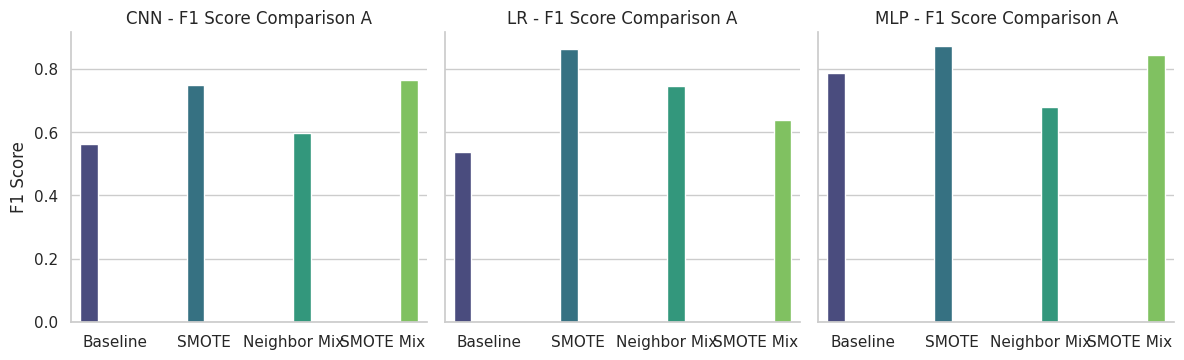

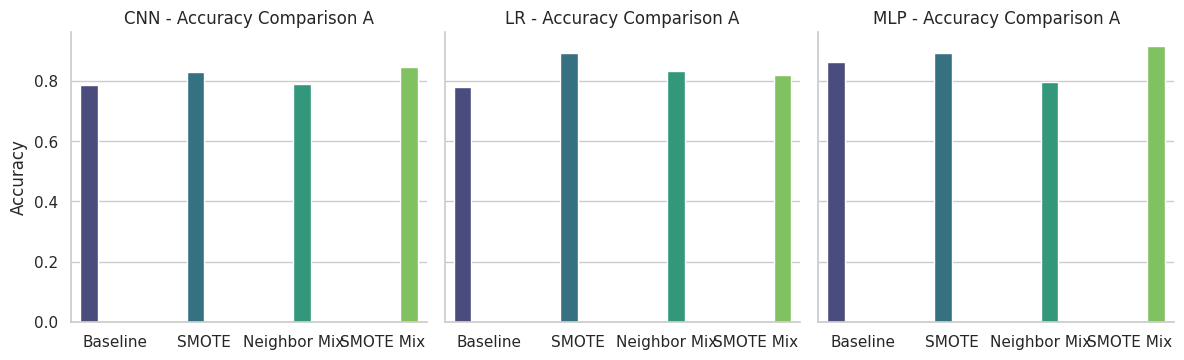

In [ ]:

g = sns.catplot(
    data=df_A, kind="bar",
    x="Method", y="F1 Score",
    hue="Method", col="Model",
    height=4, aspect=1,
    palette="viridis",
    legend=False
)
g.set_titles("{col_name} - F1 Score Comparison A")
g.set_axis_labels("", "F1 Score")

g = sns.catplot(
    data=df_A, kind="bar",
    x="Method", y="Accuracy",
    hue="Method", col="Model",
    height=4, aspect=1,
    palette="viridis",
    legend=False
)
g.set_titles("{col_name} - Accuracy Comparison A")
g.set_axis_labels("", "Accuracy")

In [ ]:
print(df_A)

   Model        Method  Precision    Recall  F1 Score  Accuracy  \
0    CNN      Baseline   0.980859  0.395424  0.563627  0.787120   
1    CNN         SMOTE   0.938118  0.620951  0.747274  0.828265   
2    CNN  Neighbor Mix   0.981320  0.428937  0.596947  0.790161   
3    CNN     SMOTE Mix   0.941196  0.643383  0.764303  0.847406   
4     LR      Baseline   0.983671  0.370256  0.538005  0.779070   
5     LR         SMOTE   0.831873  0.899013  0.864141  0.894097   
6     LR  Neighbor Mix   0.935104  0.619291  0.745115  0.831306   
7     LR     SMOTE Mix   0.957211  0.479722  0.639132  0.820215   
8    MLP      Baseline   0.979605  0.657245  0.786683  0.861717   
9    MLP         SMOTE   0.947634  0.809421  0.873092  0.892665   
10   MLP  Neighbor Mix   0.991630  0.515568  0.678414  0.795170   
11   MLP     SMOTE Mix   0.948977  0.759309  0.843614  0.916816   

                                       Accuracy Trend  
0   [0.78125, 0.6875, 0.6875, 0.6953125, 0.65625, ...  
1   [0.75, 0.828

In [ ]:
data_dict = {
    "Model": ["CNN", "CNN", "CNN", "CNN", "LR", "LR", "LR", "LR", "MLP", "MLP", "MLP", "MLP"],
    "Method": ["Baseline", "SMOTE", "Neighbor Mix", "SMOTE Mix", "Baseline", "SMOTE", "Neighbor Mix", "SMOTE Mix", "Baseline", "SMOTE", "Neighbor Mix", "SMOTE Mix"],
    "Precision": [cnn_precision_B, cnn_smote_precision_B, cnn_nx_precision_B, cnn_smote_mix_precision_B, lr_precision_B, lr_smote_precision_B, lr_mix_precision_B, lr_smote_mix_precision_B, mlp_precision_B, mlp_smote_precision_B, mlp_mix_precision_B, mlp_smote_mix_precision_B],
    "Recall": [cnn_recall_B, cnn_smote_recall_B, cnn_nx_recall_B, cnn_smote_mix_recall_B, lr_recall_B, lr_smote_recall_B, lr_mix_recall_B, lr_smote_mix_recall_B, mlp_recall_B, mlp_smote_recall_B, mlp_mix_recall_B, mlp_smote_mix_recall_B],
    "F1 Score": [cnn_f1_B, cnn_smote_f1_B, cnn_nx_f1_B, cnn_smote_mix_f1_B, lr_f1_B, lr_smote_f1_B, lr_mix_f1_B, lr_smote_mix_f1_B, mlp_f1_B, mlp_smote_f1_B, mlp_mix_f1_B, mlp_smote_mix_f1_B],
    "Accuracy": [cnn_accuracy_B, cnn_smote_accuracy_B, cnn_nx_accuracy_B, cnn_smote_mix_accuracy_B, lr_accuracy_B, lr_smote_accuracy_B, lr_mix_accuracy_B, lr_smote_mix_accuracy_B, mlp_accuracy_B, mlp_smote_accuracy_B, mlp_mix_accuracy_B, mlp_smote_mix_accuracy_B],
    "Accuracy Trend": [cnn_B, cnn_smote_B, cnn_nx_B, cnn_smote_mix_B, test_lr_B, test_lr_smote_B, test_lr_neighbor_mix_B, test_lr_smote_mix_B, mlp_B, mlp_smote_B, mlp_neighbor_B, mlp_smote_mix_B],
}
df_B = pd.DataFrame(data_dict)

df_B['Accuracy'] = df_B['Accuracy'].apply(lambda x: x.item() if torch.is_tensor(x) else x)

sns.set(style="whitegrid")


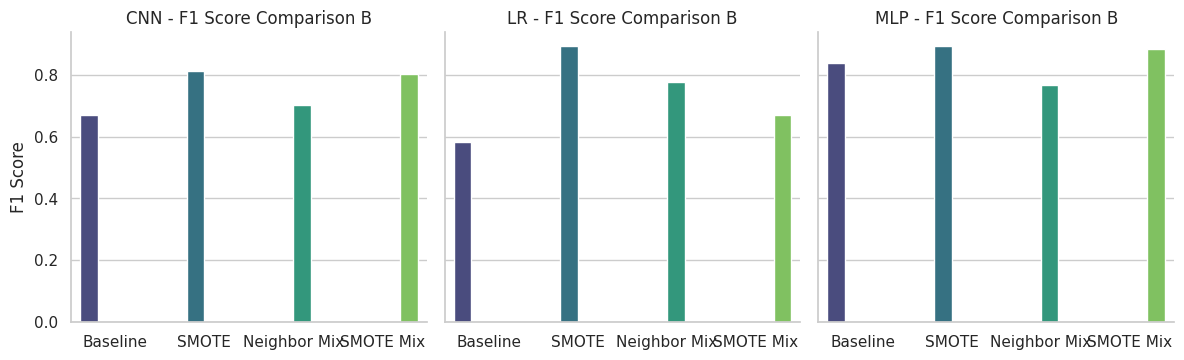

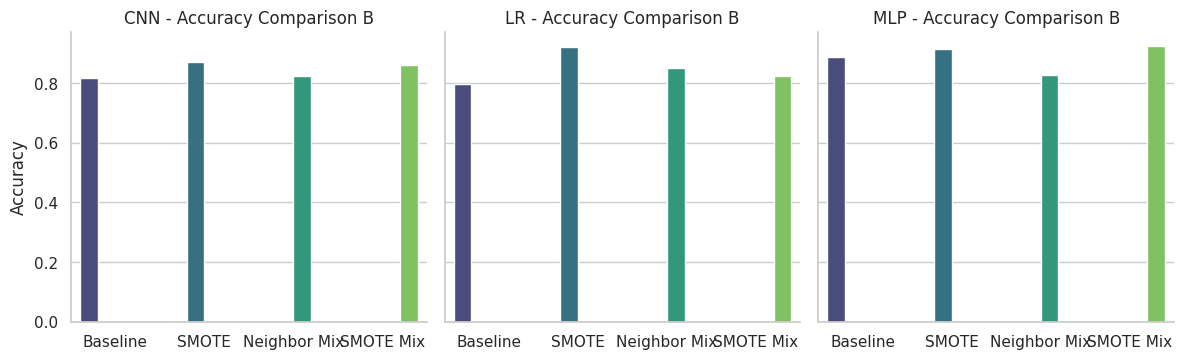

In [ ]:

g = sns.catplot(
    data=df_B, kind="bar",
    x="Method", y="F1 Score",
    hue="Method", col="Model",
    height=4, aspect=1,
    palette="viridis",
    legend=False
)
g.set_titles("{col_name} - F1 Score Comparison B")
g.set_axis_labels("", "F1 Score")

g = sns.catplot(
    data=df_B, kind="bar",
    x="Method", y="Accuracy",
    hue="Method", col="Model",
    height=4, aspect=1,
    palette="viridis",
    legend=False
)
g.set_titles("{col_name} - Accuracy Comparison B")
g.set_axis_labels("", "Accuracy")

In [ ]:
print(df_B)

   Model        Method  Precision    Recall  F1 Score  Accuracy  \
0    CNN      Baseline   0.992271  0.506637  0.670783  0.818540   
1    CNN         SMOTE   0.977246  0.694588  0.812022  0.871097   
2    CNN  Neighbor Mix   0.988047  0.543267  0.701062  0.825328   
3    CNN     SMOTE Mix   0.979883  0.681846  0.804138  0.862305   
4     LR      Baseline   0.992227  0.413322  0.583557  0.797143   
5     LR         SMOTE   0.915539  0.873921  0.894246  0.921133   
6     LR  Neighbor Mix   0.962595  0.649984  0.775988  0.849893   
7     LR     SMOTE Mix   0.982872  0.506540  0.668538  0.825263   
8    MLP      Baseline   0.990719  0.727336  0.838839  0.887905   
9    MLP         SMOTE   0.987628  0.813966  0.892427  0.914862   
10   MLP  Neighbor Mix   0.996025  0.625596  0.768502  0.828366   
11   MLP     SMOTE Mix   0.969402  0.812967  0.884320  0.925593   

                                       Accuracy Trend  
0   [0.78125, 0.8125, 0.7708333333333334, 0.734375...  
1   [0.875, 0.89